In [1]:
import sys
sys.path.append('/home/flowers/work/OpenELM/analysis_P3/diversity')

import json
import numpy as np
import matplotlib.pyplot as plt
from utils_diversity import compute_niche_filled,fill_non_zero_gen_i,compute_xaxis,compute_niche_filled_raw,compute_puzzle_correct

path_base="/home/flowers/work/OpenELM/logs/archives/"
path_json=["rd_gen_seed-1.json","elm_quality_seed-1.json","elm_nlp_seed-1.json","elm_nlp_quality_seed-1.json",
    "aces_seed-1.json","aces_quality_seed-1.json","aces_smart_quality_seed-1.json"
           ]
list_name=[i.split("_seed")[0] for i in path_json]
list_path=[path_base+path for path in path_json]


In [2]:
import pickle
import torch
from similarity_measure import (sim_matrix_llm2)
from transformers import AutoModel, AutoTokenizer
path_sim= "/home/flowers/work/OpenELM/analysis_P3/diversity/similarity_matrix_jinaai.pkl"
with open(path_sim,"rb") as f:
    list_sim = pickle.load(f)
# list_sim[0]
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-code', trust_remote_code=True,load_in_8bit=True,device_map='auto')


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [3]:
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
model_id="/home/flowers/work/hf/deepseek-coder-1.3b-instruct"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)
tokenizer.padding_size = "left" 
model.to(device)
model.eval()



def sequence_average(t, a):
    t = t * a.unsqueeze(-1)  # remove masked tokens
    sa = a.sum(1)  # get sequence-wise sum
    return (t.sum(1) / sa.unsqueeze(-1))  # average


def embed(texts, tokenizer, model, batch_size=2):
    with torch.inference_mode():
        embs = []
        print(f'Embedding {len(texts)} texts')
        for i in tqdm(range(0, len(texts), batch_size)):
            toks = tokenizer(
                texts[i:i+batch_size],
                return_tensors='pt',
                padding=True
            )
            outs = model(
                toks.input_ids.to(model.device),
                toks.attention_mask.to(model.device),
                output_hidden_states=True
            )
            embs.extend(sequence_average(outs.hidden_states[-1], toks.attention_mask.to(device)))
        return torch.vstack(embs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
import matplotlib.pyplot as plt
def sim_matrix_llm(list_code, tokenizer, model,bs=8):
    """
    Compute the similarity matrix for a list of code snippets using Salesforce/codet5p-110m-embedding model.
    Args:
        list_code (list of str): List of code snippets.
        tokenizer: Tokenizer compatible with the model.
        model: PyTorch model for embedding.
    Returns:
        torch.Tensor: Similarity matrix of size (number of codes x number of codes).
    """
    with torch.inference_mode():
        # Generate embeddings for all code snippets in a single batch
        embeddings = embed(list_code, tokenizer, model,batch_size=bs)
        
        # Normalize the embeddings
        embeddings_norm = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        # Compute the similarity matrix: (batch_size x dim) x (dim x batch_size) -> (batch_size x batch_size)
        similarity_matrix = torch.matmul(embeddings_norm, embeddings_norm.transpose(0, 1)).cpu()
    
    return similarity_matrix

list_sim=[]
list_list_data=[]
for path in list_path:
    print(path)
    with open(path) as f:
        genomes = json.load(f)

    list_data=[i["program_str"] for i in genomes][:]
    list_list_data.append(list_data)
    with torch.inference_mode():
        # list_sim.append(sim_matrix_llm(list_data,tokenizer1,model1,bs=240))
        list_sim.append(sim_matrix_llm(list_data,tokenizer, model))


# save list sim
import pickle

path = "/home/flowers/work/OpenELM/analysis_P3/diversity/similarity_matrix_deepseek1-3.pkl"
with open(path, 'wb') as f:
    pickle.dump(list_sim, f)


/home/flowers/work/OpenELM/logs/archives/rd_gen_seed-1.json
Embedding 11368 texts


 15%|█▌        | 220/1421 [01:25<07:45,  2.58it/s]


KeyboardInterrupt: 

In [9]:

path_base="/home/flowers/work/OpenELM/logs/archives/"
path_json=["rd_gen_seed-1.json","elm_quality_seed-1.json","elm_nlp_seed-1.json","elm_nlp_quality_seed-1.json",
    "aces_seed-1.json","aces_quality_seed-1.json","aces_smart_quality_seed-1.json"]

list_name=[i.split("_seed")[0] for i in path_json]
list_path=[path_base+path for path in path_json]

all_genomes = []
for id,path in enumerate(list_path):
    # if "elm_quality" in path:
    #     continue
    with open(path) as f:
        genomes = json.load(f)
    all_genomes.extend(genomes[:8000])
list_program_str = [i["program_str"] for i in all_genomes if not "random" in i["program_str"].lower()]
len(list_program_str)

51652

In [10]:
with torch.inference_mode():
    embeddings=torch.tensor(model.encode(list_program_str))scrambled_fitness

In [5]:
# from sklearn.cluster import KMeans

# # Assuming `embeddings` is a list or array of your embeddings
# kmeans = KMeans(n_clusters=1000, random_state=0).fit(embeddings)
# centers = kmeans.cluster_centers_

# # Select the nearest real data point to each cluster center
# from scipy.spatial import distance
# selected_data_indices = [distance.cdist([center], embeddings, 'euclidean').argmin() for center in centers]
# selected_data = [list_program_str[i] for i in selected_data_indices]


In [11]:
import umap
embeddings_np = embeddings_norm.numpy()
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings_np)

from sklearn.cluster import MiniBatchKMeans

# Assuming `embeddings` is a list or array of your embeddings
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0,batch_size=2048,verbose=1).fit(embeddings_reduced)
centers = kmeans.cluster_centers_

# Select the nearest real data point to each cluster center
from scipy.spatial import distance
selected_data_indices = [distance.cdist([center], embeddings_reduced, 'euclidean').argmin() for center in centers]
selected_data = [list_program_str[i] for i in selected_data_indices]

selected_genomes=[all_genomes[i] for i in selected_data_indices]
with open("selected_genomes_umap.json","w") as f:
    json.dump(selected_genomes,f,indent=4)

for i in selected_data:
    print(i)
    print("\n-----\n")

/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Init 1/3 with method k-means++
Inertia for init 1/3: 5317.79150390625
Init 2/3 with method k-means++
Inertia for init 2/3: 5072.56005859375
Init 3/3 with method k-means++
Inertia for init 3/3: 5258.87646484375
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/2522: mean batch inertia: 0.8120056986808777
Minibatch step 2/2522: mean batch inertia: 0.6950749158859253, ewa inertia: 0.6950749158859253
Minibatch step 3/2522: mean batch inertia: 0.6520527005195618, ewa inertia: 0.6916633232554754
Minibatch step 4/2522: mean batch inertia: 0.6803646087646484, ewa inertia: 0.6907673533301193
Minibatch step 5/2522: mean batch inertia: 0.6322392225265503, ewa inertia: 0.6861261664915732
Minibatch step 6/2522: mean batch inertia: 0.6255418062210083, ewa inertia: 0.6813219239564207
Minibatch step 7/2522: mean batch inertia: 0.64079749584198, ewa inertia: 0.678108401846248
Minibatch step 8/2522: mean batch inertia: 0.6212438941001892, ewa inertia: 0.6735991376461463
Minibatch step 9/

/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [7]:
import umap
from sklearn.cluster import MiniBatchKMeans

embeddings_np = embeddings_norm.numpy()
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings_np)
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0,batch_size=2048,verbose=1).fit(embeddings_reduced)
centers = kmeans.cluster_centers_


/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 191.46957397460938
Init 2/3 with method k-means++
Inertia for init 2/3: 191.90756225585938
Init 3/3 with method k-means++
Inertia for init 3/3: 191.78512573242188
[MiniBatchKMeans] Reassigning 242 cluster centers.
Minibatch step 1/4005: mean batch inertia: 0.03570986166596413
Minibatch step 2/4005: mean batch inertia: 0.08053173124790192, ewa inertia: 0.08053173124790192
Minibatch step 3/4005: mean batch inertia: 0.07222096621990204, ewa inertia: 0.08011678563123276
Minibatch step 4/4005: mean batch inertia: 0.054885704070329666, ewa inertia: 0.07885703076363083
Minibatch step 5/4005: mean batch inertia: 0.04915366321802139, ewa inertia: 0.07737398051231964
Minibatch step 6/4005: mean batch inertia: 0.05307937040925026, ewa inertia: 0.0761609824384972
Minibatch step 7/4005: mean batch inertia: 0.05516577884554863, ewa inertia: 0.07511271941185414
Minibatch step 8/4005: mean batch inertia: 0.04993458464741707, ewa inertia: 0.073855608

In [ ]:
centers

In [10]:
last_id=0
list_all_emb=[]
for id,path in enumerate(list_path):
    # if "elm_quality" in path:
    #     continue
    with open(path) as f:
        genomes = json.load(f)

    len_genomes = len(genomes)
    list_all_emb.append(embeddings_reduced[last_id:last_id+len_genomes])
    last_id=last_id+len_genomes

In [24]:
last_id

82036

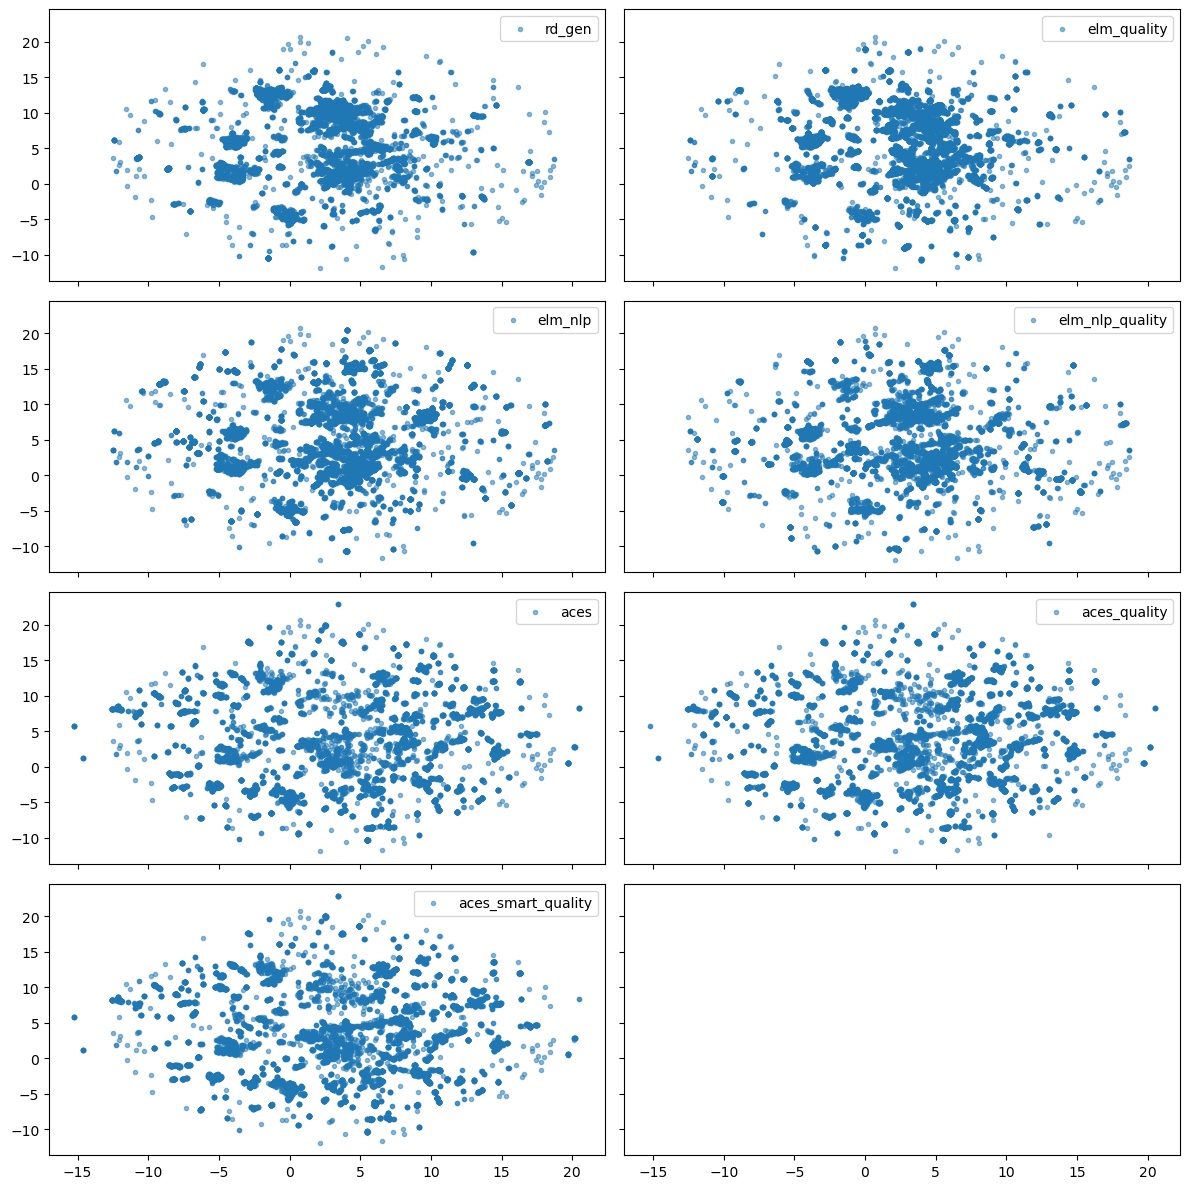

In [22]:
fig,axs = plt.subplots(4,2,figsize=(12,12),sharex=True,sharey=True)
#flatten the axs
axs=axs.flatten()
for id,emb in enumerate(list_all_emb):
    axs[id].scatter(emb[:,0],emb[:,1],label=list_name[id],alpha=0.5,marker=".")
    axs[id].legend()
    axs[id].
plt.tight_layout()


In [ ]:
from scipy.spatial import distance
selected_data_indices = [distance.cdist([center], embeddings_reduced, 'euclidean').argmin() for center in centers]
selected_data = [list_program_str[i] for i in selected_data_indices]

selected_genomes=[all_genomes[i] for i in selected_data_indices]
with open("selected_genomes_umap.json","w") as f:
    json.dump(selected_genomes,f,indent=4)

for i in selected_data:
    print(i)
    print("\n-----\n")

In [ ]:

from sklearn.cluster import MiniBatchKMeans

# Assuming `embeddings` is a list or array of your embeddings
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0,batch_size=2048,verbose=1).fit(embeddings_norm)
centers = kmeans.cluster_centers_

# Select the nearest real data point to each cluster center
from scipy.spatial import distance
selected_data_indices = [distance.cdist([center], embeddings, 'euclidean').argmin() for center in centers]
selected_data = [list_program_str[i] for i in selected_data_indices]


In [27]:
selected_genomes=[all_genomes[i] for i in selected_data_indices]
with open("selected_genomes.json","w") as f:
    json.dump(selected_genomes,f,indent=4)

In [ ]:
for i in selected_data:
    print(i)
    print("\n-----\n")

In [9]:

# list_fitness = [i["fitness"] for i in all_genomes]
# 

sim = sim_matrix_llm2(list_program_str,model)





Number of puzz with similarity greater than 0.7: 95774737


In [12]:
tres=0.8

sim = sim-torch.eye(sim.shape[0])
# Find the elements greater than the threshold. This returns a boolean matrix.
mask = sim > tres

# Use torch.triu to consider only upper triangle, including diagonal
# since j ranges from i to n in your loop, indicating you want upper triangular matrix indices
mask = torch.triu(mask)

# Extract the indices where the condition is True
list_idx = mask.nonzero(as_tuple=False)

# Print the number of elements above the threshold
print("\n==========\n")
print(f"Number of puzz with similarity greater than {tres}: {mask.sum().item()}")
# idx_2_remove = set(list_idx[:,1].flatten().tolist())
# print("before dedup",len(out))

# print("puzzle 2 remove: ",len(idx_2_remove))
# for i in range(len(out)):
#     if i in idx_2_remove:
#         out[i]["duplicate"]=True
#     else:
#         out[i]["duplicate"]=False
# with open(path_embed, "w") as f:
#     json.dump(out, f, indent=4)

idx_2_remove = set(list_idx[:,1].flatten().tolist())
print("before dedup",len(list_program_str))

print("puzzle 2 remove: ",len(idx_2_remove))



Number of puzz with similarity greater than 0.8: 20802009
before dedup 58756
puzzle 2 remove:  58098


# est ce les puzzles tres similaires sont tjr dans la mm niche ou ya un effet de random?


In [2]:
import pickle
import torch
path_sim= "/home/flowers/work/OpenELM/analysis_P3/diversity/similarity_matrix_jinaai.pkl"
with open(path_sim,"rb") as f:
    list_sim = pickle.load(f)
list_sim[0]

tensor([[1.0000, 0.7159, 0.6222,  ..., 0.4977, 0.5809, 0.4072],
        [0.7159, 1.0000, 0.4916,  ..., 0.6369, 0.5082, 0.5880],
        [0.6222, 0.4916, 1.0000,  ..., 0.3575, 0.5593, 0.2826],
        ...,
        [0.4977, 0.6369, 0.3575,  ..., 1.0000, 0.3741, 0.5873],
        [0.5809, 0.5082, 0.5593,  ..., 0.3741, 1.0000, 0.2940],
        [0.4072, 0.5880, 0.2826,  ..., 0.5873, 0.2940, 1.0000]])

Processing rd_gen
Processing elm_quality
Processing elm_nlp
Processing elm_nlp_quality
Processing aces
Processing aces_quality
Processing aces_smart_quality


/tmp/ipykernel_28142/3944431970.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


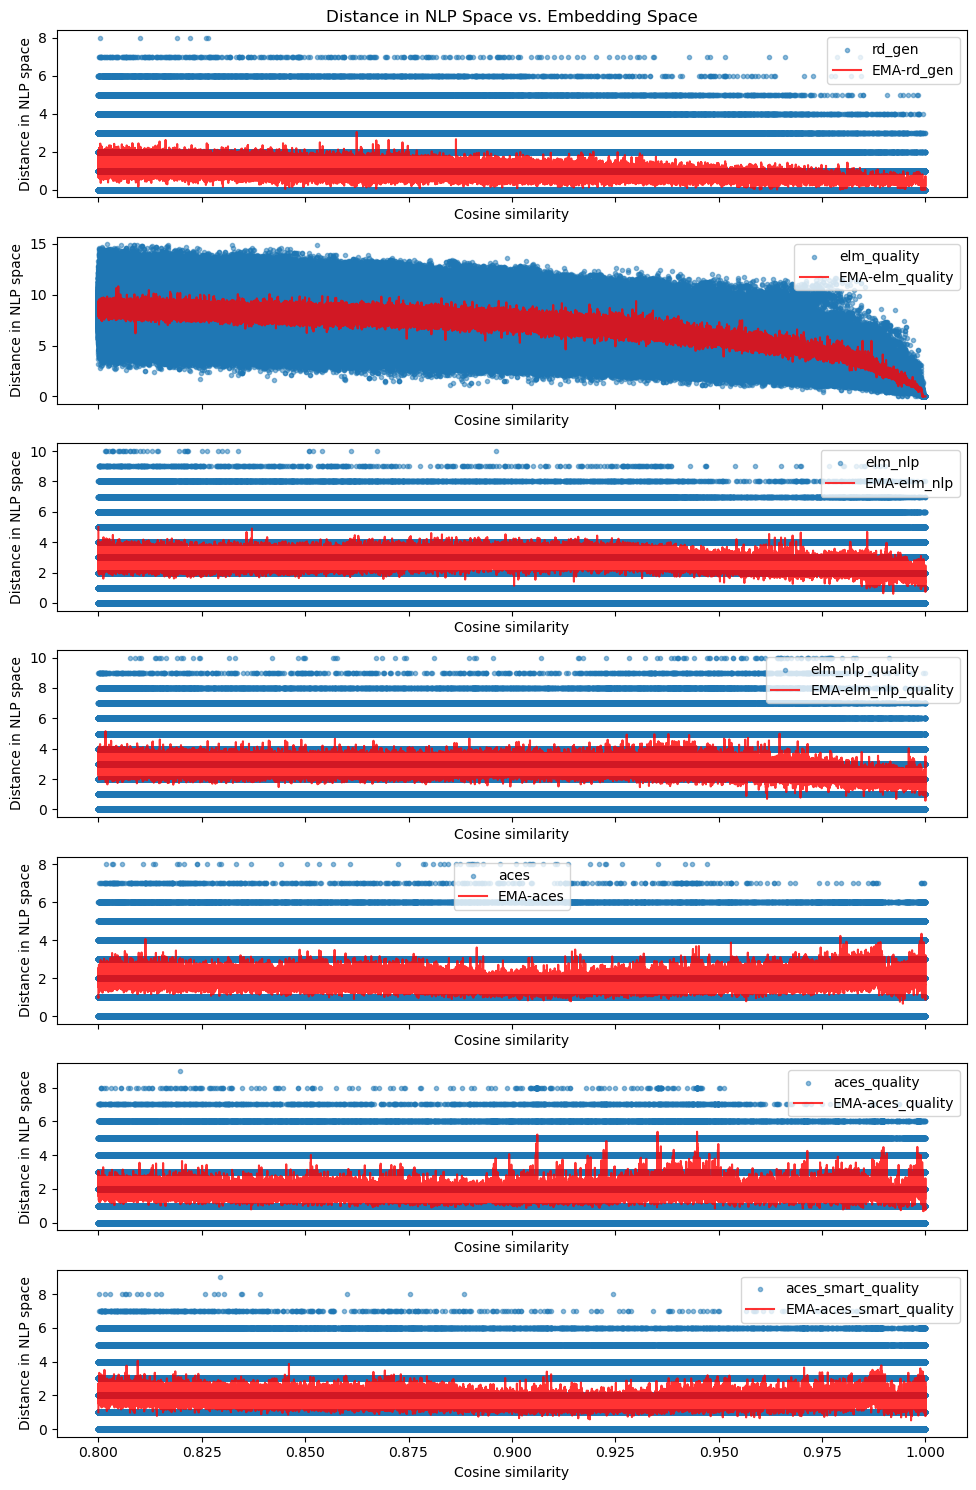

In [3]:
threshold = 0.8
fig, axs = plt.subplots(len(list_path), 1, figsize=(10, 15), sharex=True)

# Possible optimization: Load JSON data once if applicable
genome_data = []
for path in list_path:
    with open(path) as f:
        genome_data.append(json.load(f))

for id, path in enumerate(list_path):
    print("Processing", list_name[id])
    ax = axs[id]
    sim = list_sim[id] - torch.eye(list_sim[id].shape[0])
    sim = torch.triu(sim)
    mask = sim > threshold
    list_idx = torch.nonzero(mask, as_tuple=False)
    
    genomes = genome_data[id]
    list_dist = []
    list_sim_ = []
    
    for idx1, idx2 in list_idx:
        emb_diff = np.abs(np.array(genomes[idx1]["emb"]) - np.array(genomes[idx2]["emb"]))
        list_dist.append(emb_diff.sum())
        list_sim_.append(list_sim[id][idx1, idx2])
    
    # Sorting by list_sim_
    sorted_pairs = sorted(zip(list_sim_, list_dist), key=lambda x: x[0])
    list_sim_, list_dist = zip(*sorted_pairs)

    ax.scatter(list_sim_, list_dist, label=list_name[id], alpha=0.5, marker=".")
    
    # Calculate Exponential Moving Average (EMA)
    ema = list_dist[0]
    alpha = 0.05
    ema_list = [ema]  # store the first element
    for dist in list_dist[1:]:
        ema = alpha * dist + (1 - alpha) * ema
        ema_list.append(ema)
    
    ax.plot(list_sim_, ema_list, label="EMA-" + list_name[id], alpha=0.8, color='red')
    ax.legend()
    ax.set_xlabel("Cosine similarity")
    ax.set_ylabel("Distance in NLP space")

axs[0].set_title("Distance in NLP Space vs. Embedding Space")
plt.tight_layout()
plt.show()

In [9]:
# given this code can you plot the evolution of the distance between the genomes that are similar along their similarity values?
trashold = 0.8
fig, axs = plt.subplots(len(list_path),1, figsize=(10, 15), sharex=True)
for id,path in enumerate(list_path):
    ax=axs[id]
    sim = list_sim[id]-torch.eye(list_sim[id].shape[0])
    sim = torch.triu(sim)
    mask = sim > trashold
    mask = torch.triu(mask)
    list_idx = mask.nonzero(as_tuple=False)
    # break
    with open(path) as f:
        genomes = json.load(f)
    list_dist=[]
    list_sim_=[]
    for idx1,idx2 in list_idx:
        list_dist.append(np.abs(np.array(genomes[idx1]["emb"])-np.array(genomes[idx2]["emb"])).sum())
        list_sim_.append(list_sim[id][idx1,idx2])
    #sort by list_sim_
    list_dist = [x for _,x in sorted(zip(list_sim_,list_dist))]
    list_sim_ = sorted(list_sim_)
    ax.scatter(list_sim_,list_dist,label=list_name[id],alpha=0.5,marker=".")
    ema = list_dist[0]
    alpha = 0.05
    for i in range(1,len(list_dist)):
        ema = alpha * list_dist[i] + (1-alpha) * ema
        list_dist[i] = ema
    ax.plot(list_sim_,list_dist,label="ema-"+list_name[id],alpha=0.8,color='red')
    ax.legend()
    ax.set_xlabel("cosine similarity")
    ax.set_ylabel("distance \nNLP space")
axs[0].set_title("distance NLP space / embedding space")
plt.tight_layout()
    # for i in genomes:
    #     if i["idx_generation"]!=-1:
    #         list_dist.append(np.abs(np.array(i["emb"])-np.array(i["target_skills"])).sum())
    # ema = list_dist[0]similarity
    #     list_dist[i] = ema
    # plt.plot(list_dist,label=list_name[id],alpha=0.7)
    # plt.legend()
    # plt.show()

KeyboardInterrupt: 

/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


# relation entre case/embedding des offspring et des parents 


In [ ]:
list_qual=['/home/flowers/work/OpenELM/logs/archives/rd_gen_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_nlp_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_nlp_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_smart_quality_seed-1.json'
 ]
fig, axs = plt.subplots(len(list_qual)//2+1,2, figsize=(12, 15), sharex=True)

for id_base,path_base in enumerate(list_qual):
    ax=axs.flatten()[id_base]
    with open(path_base) as f:
        genomes = json.load(f)
    list_fitness = [i["fitness"] for i in genomes]
    list_puzzles_fewshot=[i["puzzles_id_fewshot"] for i in genomes]
    list_unique_id=[i["unique_id"] for i in genomes]    

    list_fitness_new_puzzle=[]
    list_fitness_orig_puzzle=[]
    for puzzle_fw,fitness in zip(list_puzzles_fewshot,list_fitness):
        if puzzle_fw==[]:
            continue
        fitness_orig=0
        puzzle_fw=[puzzle_fw[-1]]
        for puz in puzzle_fw:
            puzle_origin = puz
            idx_origin = list_unique_id.index(puzle_origin)
            fitness_orig+=list_fitness[idx_origin]
        fitness_orig/=len(puzzle_fw)
        puzle_origin = puzzle_fw[-1]
        idx_origin = list_unique_id.index(puzle_origin)
        fitness_orig = list_fitness[idx_origin]
        list_fitness_new_puzzle.append(fitness)
        list_fitness_orig_puzzle.append(fitness_orig)

    ax.scatter(list_fitness_orig_puzzle,list_fitness_new_puzzle,alpha=0.5,marker=".")
    ax.set_xlabel("fitness original puzzle")
    ax.set_ylabel("fitness new puzzle")
    # fit a line
    from sklearn.linear_model import LinearRegression
    X = np.array(list_fitness_orig_puzzle).reshape(-1,1)
    y = np.array(list_fitness_new_puzzle).reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    ax.plot(X, reg.predict(X), color='red', linewidth=3,label=f"y={reg.coef_[0][0]:.4f}x+{reg.intercept_[0]:.4f}")
    ax.set_title(f"{path_base.split('archives/')[1].split('_seed')[0]} R2={reg.score(X,y):.6f}")
    #plot x=y
    ax.plot([0,1],[0,1],color="black",label="x=y")
    ax.set_xlim(0.3,0.75)
    ax.set_ylim(0.3,0.75)
    ax.legend()    
plt.tight_layout()
plt.show()

# show semantic space related features

Text(0, 0.5, 'Number of niche filled')

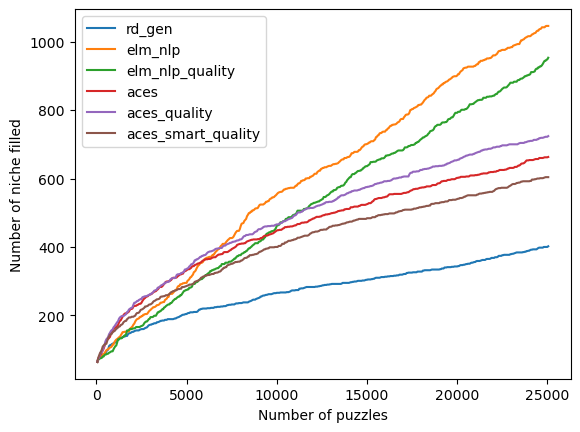

In [5]:
use_trainset=True

for id,path in enumerate(list_path):
    if "elm_quality" in path:
        continue
    with open(path) as f:
        genomes = json.load(f)

    n_niche_filled = compute_niche_filled(genomes, use_trainset = use_trainset)
    plt.plot(compute_xaxis(n_niche_filled,use_trainset),n_niche_filled,label=list_name[id])
plt.legend()
plt.xlabel("Number of puzzles")
plt.ylabel("Number of niche filled")



Text(0, 0.5, 'Number of niche filled')

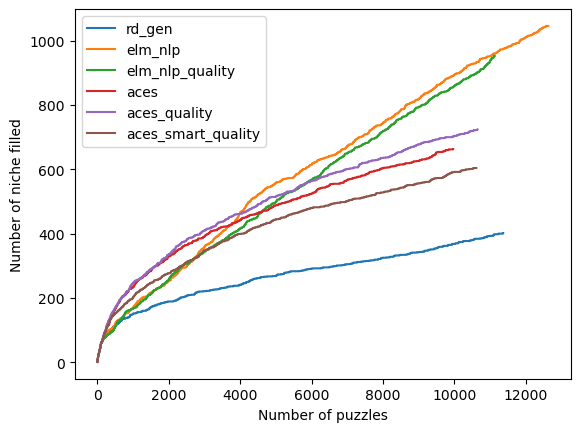

In [6]:

use_trainset=True

for id,path in enumerate(list_path):
    if "elm_quality" in path:
        continue
    with open(path) as f:
        genomes = json.load(f)

    n_niche_filled = compute_niche_filled_raw(genomes, use_trainset = use_trainset)
    plt.plot(n_niche_filled,label=list_name[id])
plt.legend()
plt.xlabel("Number of puzzles")
plt.ylabel("Number of niche filled")


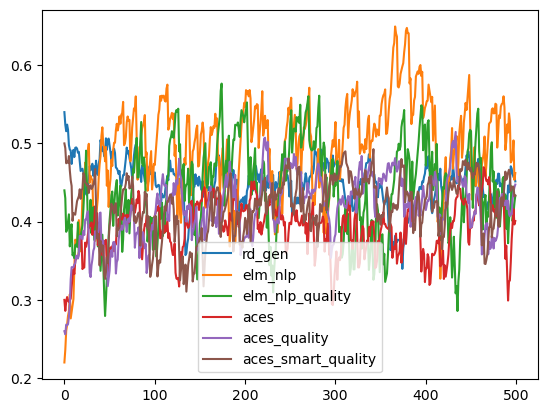

In [7]:
n_puzzle_by_gen=50
for id,path in enumerate(list_path):
    if "elm_quality" in path:
        continue
    with open(path) as f:
        genomes = json.load(f)
    percent_correct_puz=compute_puzzle_correct(genomes[:])/n_puzzle_by_gen
    # ema over percent_correct_puz
    ema = percent_correct_puz[0]
    alpha = 0.1
    for i in range(1,len(percent_correct_puz)):
        ema = alpha * percent_correct_puz[i] + (1-alpha) * ema
        percent_correct_puz[i] = ema


    plt.plot(percent_correct_puz,label=list_name[id])
plt.legend()

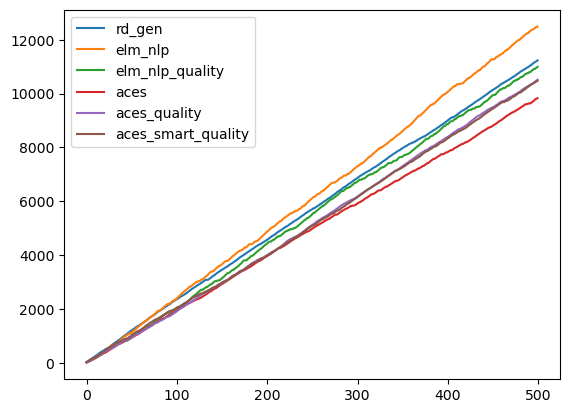

In [8]:

n_puzzle_by_gen=50
for id,path in enumerate(list_path):
    if "elm_quality" in path:
        continue
    with open(path) as f:
        genomes = json.load(f)

    plt.plot(np.cumsum(compute_puzzle_correct(genomes[:])),label=list_name[id])
plt.legend()
# plt.plot(np.cumsum(compute_puzzle_correct(genomes[:])))

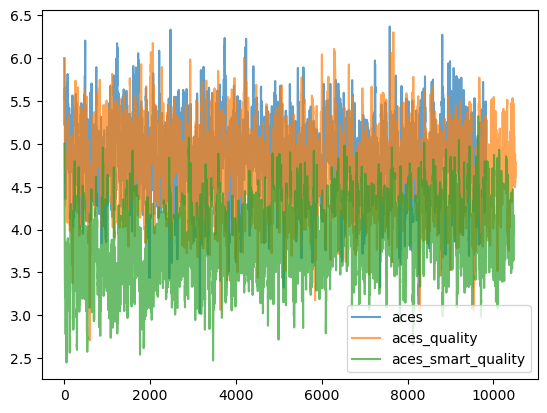

In [9]:
for id,path in enumerate(list_path):
    list_dist=[]
    if not "aces" in path:
        continue
    with open(path) as f:
        genomes = json.load(f)
    for i in genomes:
        if i["idx_generation"]!=-1:
            list_dist.append(np.abs(np.array(i["emb"])-np.array(i["target_skills"])).sum())
    ema = list_dist[0]
    alpha = 0.1
    for i in range(1,len(list_dist)):
        ema = alpha * list_dist[i] + (1-alpha) * ema
        list_dist[i] = ema
    plt.plot(list_dist,label=list_name[id],alpha=0.7)
plt.legend()

In [9]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
enc.encode("hello world")

[15339, 1917]

Text(0, 0.5, 'Number of puzzles')

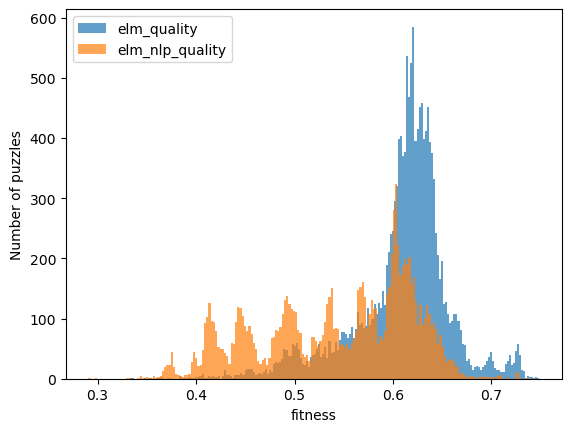

In [20]:
use_trainset=True
list_qual=[#'/home/flowers/work/OpenELM/logs/archives/rd_gen_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_quality_seed-1.json',
#  '/home/flowers/work/OpenELM/logs/archives/elm_nlp_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_nlp_quality_seed-1.json',
#  '/home/flowers/work/OpenELM/logs/archives/aces_seed-1.json',
#  '/home/flowers/work/OpenELM/logs/archives/aces_quality_seed-1.json',
#  '/home/flowers/work/OpenELM/logs/archives/aces_smart_quality_seed-1.json'
 ]
for id,path in enumerate(list_qual):
    # if "elm_quality" in path:
    #     continue
    with open(path) as f:
        genomes = json.load(f)

    list_fitness = [i["fitness"] for i in genomes]
    plt.hist(list_fitness,label=path.split("archives/")[1].split("_seed")[0],alpha=0.7,bins=200)
plt.legend()
plt.xlabel("fitness")
plt.ylabel("Number of puzzles")


3

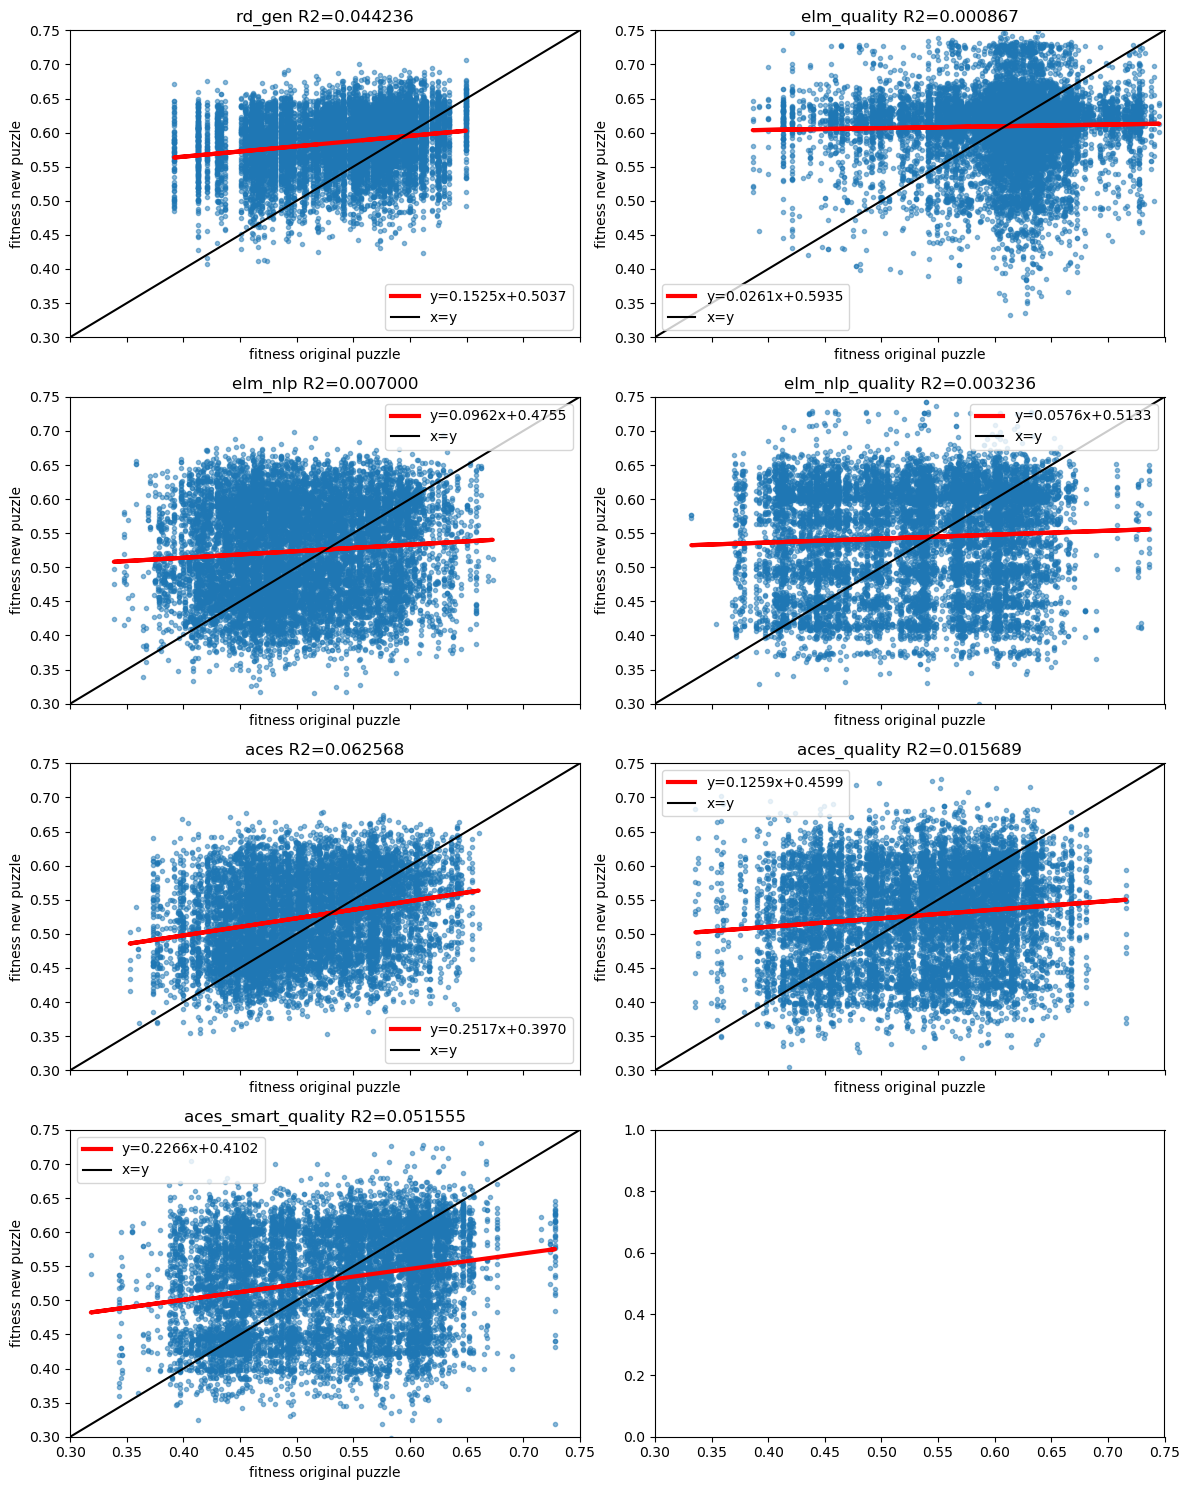

In [69]:
list_qual=['/home/flowers/work/OpenELM/logs/archives/rd_gen_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_nlp_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/elm_nlp_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_quality_seed-1.json',
 '/home/flowers/work/OpenELM/logs/archives/aces_smart_quality_seed-1.json'
 ]
fig, axs = plt.subplots(len(list_qual)//2+1,2, figsize=(12, 15), sharex=True)

for id_base,path_base in enumerate(list_qual):
    ax=axs.flatten()[id_base]
    with open(path_base) as f:
        genomes = json.load(f)
    list_fitness = [i["fitness"] for i in genomes]
    list_puzzles_fewshot=[i["puzzles_id_fewshot"] for i in genomes]
    list_unique_id=[i["unique_id"] for i in genomes]    

    list_fitness_new_puzzle=[]
    list_fitness_orig_puzzle=[]
    for puzzle_fw,fitness in zip(list_puzzles_fewshot,list_fitness):
        if puzzle_fw==[]:
            continue
        fitness_orig=0
        puzzle_fw=[puzzle_fw[-1]]
        for puz in puzzle_fw:
            puzle_origin = puz
            idx_origin = list_unique_id.index(puzle_origin)
            fitness_orig+=list_fitness[idx_origin]
        fitness_orig/=len(puzzle_fw)
        puzle_origin = puzzle_fw[-1]
        idx_origin = list_unique_id.index(puzle_origin)
        fitness_orig = list_fitness[idx_origin]
        list_fitness_new_puzzle.append(fitness)
        list_fitness_orig_puzzle.append(fitness_orig)

    ax.scatter(list_fitness_orig_puzzle,list_fitness_new_puzzle,alpha=0.5,marker=".")
    ax.set_xlabel("fitness original puzzle")
    ax.set_ylabel("fitness new puzzle")
    # fit a line
    from sklearn.linear_model import LinearRegression
    X = np.array(list_fitness_orig_puzzle).reshape(-1,1)
    y = np.array(list_fitness_new_puzzle).reshape(-1,1)
    reg = LinearRegression().fit(X, y)
    ax.plot(X, reg.predict(X), color='red', linewidth=3,label=f"y={reg.coef_[0][0]:.4f}x+{reg.intercept_[0]:.4f}")
    ax.set_title(f"{path_base.split('archives/')[1].split('_seed')[0]} R2={reg.score(X,y):.6f}")
    #plot x=y
    ax.plot([0,1],[0,1],color="black",label="x=y")
    ax.set_xlim(0.3,0.75)
    ax.set_ylim(0.3,0.75)
    ax.legend()    
plt.tight_layout()
plt.show()

# check correlation after and befor mutation

# diversity with similarity matrix

In [5]:
import matplotlib.pyplot as plt
from similarity_measure import (sim_naive,sim_base_naive_plus,
    sim_paper,sim_base_IO
    ,sim_base_ast,sim_base_tiktok,
    sim_matrix_llm,sim_matrix_llm2,compute_similarity_matrix,sim_matrix_tiktoken)

list_sim_function=[sim_naive,sim_base_naive_plus,sim_paper,sim_base_IO,sim_base_tiktok,sim_base_ast]
list_name_sim = [i.__name__ for i in list_sim_function] + ["Salesforce/codet5p-110m-embedding", 'jinaai/jina-embeddings-v2-base-code']



In [2]:
path= list_path[0]
with open(path) as f:
    genomes = json.load(f)

list_data=[i["program_str"] for i in genomes][:]

In [7]:

list_sim=[]
for sim in list_sim_function:
    print(sim.__name__)
    similarity_matrix = compute_similarity_matrix(list_data, sim=sim)
    list_sim.append(similarity_matrix)

sim_naive


100%|██████████| 80200/80200 [00:01<00:00, 41253.01it/s]


sim_base_naive_plus


100%|██████████| 80200/80200 [00:39<00:00, 2032.18it/s]


sim_paper


100%|██████████| 80200/80200 [00:01<00:00, 78471.38it/s]


sim_base_IO


100%|██████████| 80200/80200 [00:25<00:00, 3161.38it/s]


sim_base_tiktok


100%|██████████| 80200/80200 [00:10<00:00, 7742.31it/s] 


sim_base_ast


100%|██████████| 80200/80200 [00:15<00:00, 5150.94it/s]


In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
# checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cuda"  # for GPU usage or "cpu" for CPU usage

# tokenizer1 = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

# model1 = AutoModel.from_pretrained(checkpoint, trust_remote_code=True,load_in_8bit=True,device_map='auto')
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-code', trust_remote_code=True,load_in_8bit=True,device_map='auto')


model.safetensors:   0%|          | 0.00/322M [00:00<?, ?B/s]

In [6]:
import matplotlib.pyplot as plt
from similarity_measure import (sim_naive,sim_base_naive_plus,
    sim_paper,sim_base_IO
    ,sim_base_ast,sim_base_tiktok,
    sim_matrix_llm,sim_matrix_llm2,compute_similarity_matrix,sim_matrix_tiktoken)
list_sim=[]
list_list_data=[]
for path in list_path:
    print(path)
    with open(path) as f:
        genomes = json.load(f)

    list_data=[i["program_str"] for i in genomes][:]
    list_list_data.append(list_data)
    with torch.inference_mode():
        # list_sim.append(sim_matrix_llm(list_data,tokenizer1,model1,bs=240))
        list_sim.append(sim_matrix_llm2(list_data,model))


# save list sim
import pickle

path = "/home/flowers/work/OpenELM/analysis_P3/diversity/similarity_matrix_jinaai.pkl"
with open(path, 'wb') as f:
    pickle.dump(list_sim, f)


/home/flowers/work/OpenELM/logs/archives/rd_gen_seed-1.json
/home/flowers/work/OpenELM/logs/archives/elm_quality_seed-1.json
/home/flowers/work/OpenELM/logs/archives/elm_nlp_seed-1.json
/home/flowers/work/OpenELM/logs/archives/elm_nlp_quality_seed-1.json
/home/flowers/work/OpenELM/logs/archives/aces_seed-1.json
/home/flowers/work/OpenELM/logs/archives/aces_quality_seed-1.json
/home/flowers/work/OpenELM/logs/archives/aces_smart_quality_seed-1.json


In [7]:
# save list sim
import pickle

path = "/home/flowers/work/OpenELM/analysis_P3/diversity/similarity_matrix_jinaai.pkl"
with open(path, 'wb') as f:
    pickle.dump(list_sim, f)


given a similarity matrix (torch) plot the k=50 closest element for each rows 

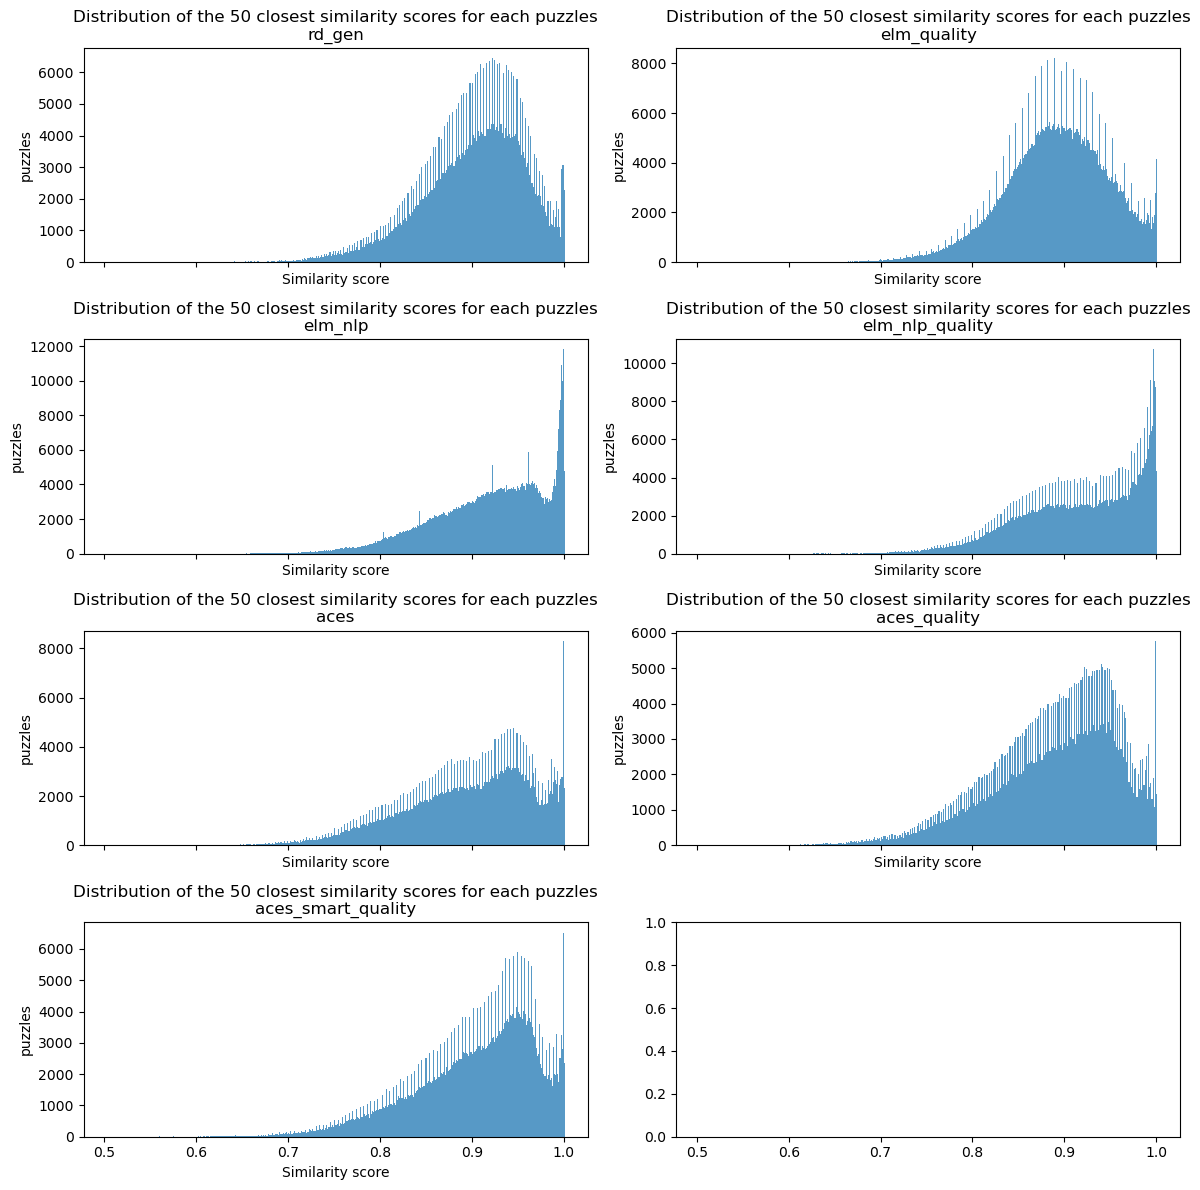

In [7]:
# Assume sim_matrix is your similarity matrix and is of shape (n, n)
fig, axs = plt.subplots(len(list_sim)//2+1,2, figsize=(12, 12), sharex=True)

for id,sim_matrix in enumerate(list_sim):
    ax=axs.flatten()[id]

    n = sim_matrix.shape[0]
    k = 50  # number of closest elements
    # set diagonal to 0
    sim_matrix = sim_matrix - torch.eye(n)
    # We will use topk to find the k largest values (closest elements) along each row
    values, indices = torch.topk(sim_matrix, k=k, dim=1)

    # Flatten the values tensor to get a simple list of the top k similarities for all rows
    flat_values = values.flatten()

    # Plotting the histogram of the closest element values
    ax.hist(flat_values.numpy(), bins=400, alpha=0.75)
    ax.set_title('Distribution of the 50 closest similarity scores for each puzzles\n'+list_path[id].split("archives/")[1].split("_seed")[0])
    ax.set_xlabel('Similarity score')
    ax.set_ylabel('puzzles')
    # ax.set_ylim(0,6500)
    # ax.set_xlim(0.,1.005)
    #show x values
    
plt.tight_layout()
plt.show()


tensor(48312)

In [16]:
tres=0.97
for i in range(len(list_sim)):

    sim = list_sim[i]-torch.eye(list_sim[i].shape[0])
    # Find the elements greater than the threshold. This returns a boolean matrix.
    mask = sim > tres

    # Use torch.triu to consider only upper triangle, including diagonal
    # since j ranges from i to n in your loop, indicating you want upper triangular matrix indices
    mask = torch.triu(mask)

    # Extract the indices where the condition is True
    list_idx = mask.nonzero(as_tuple=False)

    # Print the number of elements above the threshold
    print("\n==========\n")
    print(f"Number of puzz with similarity greater than {tres}: {mask.sum().item()}")
    print(list_path[i].split("archives/")[1].split("_seed")[0])
    print(len(set(list_idx[:,1].flatten().tolist())))
    print(len(set(list_idx[:,0].flatten().tolist())))





Number of puzz with similarity greater than 0.97: 29417
rd_gen
3770
3810


Number of puzz with similarity greater than 0.97: 30139
elm_quality
6132
6098


Number of puzz with similarity greater than 0.97: 291496
elm_nlp
6834
6740


Number of puzz with similarity greater than 0.97: 168845
elm_nlp_quality
5950
5893


Number of puzz with similarity greater than 0.97: 62107
aces
4016
4037


Number of puzz with similarity greater than 0.97: 38484
aces_quality
3685
3653


Number of puzz with similarity greater than 0.97: 44307
aces_smart_quality
4573
4537


In [ ]:
import pandas as pd

# Create data based on the user's input
data = {
    'Category': [
        'rd_gen', 'elm_quality', 'elm_nlp', 'elm_nlp_quality', 
        'aces', 'aces_quality', 'aces_smart_quality'
    ],
    'Number of Puzzles dedup': [3770, 6132, 6834, 5950, 4016, 3685, 4573]
}

# Create DataFrame
df = pd.DataFrame(data)
df
print(df.to_html())

In [ ]:
list_puz=list_list_data[-1]
for idx1,idx2 in list_idx:
    print(f"Similarity {list_sim[-1][idx1,idx2]}")
    print(list_puz[idx1])
    print("\n----\n")
    print(list_puz[idx2])
    print("\n=============\n")

In [ ]:
def compute_all_sim(list_data,name_data="ACES",list_sim_function=list_sim_function,list_name_sim=list_name_sim):
    list_sim = []

    # Compute similarity matrices and add them to list_sim
    for sim in list_sim_function:
        similarity_matrix = compute_similarity_matrix(list_data, sim=sim)
        list_sim.append(similarity_matrix)

    # Add similarity matrices from LLM methods
    list_sim.append(sim_matrix_llm(list_data))
    list_sim.append(sim_matrix_llm2(list_data))
    # list_sim.append(sim_matrix_deepseek(list_data))
    # list_sim.append(sim_matrix_deepseek7b(list_data))


    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 24), dpi=200)
    axes = axes.flatten()  # Flatten the array of axes for easy indexing

    for i, ax in enumerate(axes):
        if i < len(list_sim):
            im = ax.imshow(list_sim[i], cmap="viridis")
            ax.set_title(list_name_sim[i]+"\n("+name_data+")")
            fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.savefig("/home/flowers/work/OpenELM/analysis_P3/diversity/plot/matrix_similarity_"+name_data+".png")
    plt.show()
    return list_sim